In [2]:
import os
os.environ['XLA_PYTHON_CLIENT_PREALLOCATE'] = 'false'


from poclaps.train.ppo import reload

policy_dir = 'outputs/2024-06-14/15-39-35/'
config, pretrained_policy, env, env_params, _ = reload(policy_dir)

I0000 00:00:1731548524.184172  272235 tfrt_cpu_pjrt_client.cc:349] TfrtCpuClient created.


In [3]:
import jax
import numpy as np
from poclaps.rollout_fake_msgs import rollout_with_msgs


N_ACTIONS = env.action_space(env_params).n


def sample_obs_modelling_batch(rng,
                               noise_dim: int = 64,
                               rollout_steps: int = 500,
                               return_traj: bool = False):
    rng, rollout_rng = jax.random.split(rng)
    _, traj_batch, metrics = rollout_with_msgs(
        env, env_params, pretrained_policy,
        steps=rollout_steps,
        rng=rollout_rng
    )

    n_msgs = env_params.grid_size * env_params.grid_size
    actions = jax.nn.one_hot(traj_batch.action, N_ACTIONS)
    msgs = jax.nn.one_hot(traj_batch.message, n_msgs)

    *batch_shape, _ = traj_batch.obs.shape
    noise = jax.random.normal(rng, (*batch_shape, noise_dim))
    inputs = (actions, msgs, noise, traj_batch.obs, traj_batch.done)
    if return_traj:
        return inputs, metrics, traj_batch
    return inputs, metrics

In [108]:
inputs, _ = sample_obs_modelling_batch(jax.random.PRNGKey(0), rollout_steps=5)

In [109]:
actions, msgs, noise, obs, dones = inputs
T = 4
actions[:T, 0].argmax(-1), msgs[:T, 0].argmax(-1), dones[:T, 0], obs[:T, 0].reshape(-1, 2, 2, 5).argmax(-1)

(Array([1, 1, 4, 1], dtype=int32),
 Array([17, 17, 17, 17], dtype=int32),
 Array([False, False, False,  True], dtype=bool),
 Array([[[0, 4],
         [1, 1]],
 
        [[0, 3],
         [1, 1]],
 
        [[0, 2],
         [1, 1]],
 
        [[1, 2],
         [1, 1]]], dtype=int32))

In [138]:
from typing import Iterable
from poclaps.simple_gridworld_game import stringify_grid


def get_goals_and_pos(obs, n_envs=4):
    """
    Args:
        obs: (T, n_envs, 20) shaped array of observations.
    Returns:
        goal_pos: (T, n_envs, 2) shaped array of goal positions.
        agent_pos: (T, n_envs, 2) shaped array of agent positions.
    """
    env_states = obs.reshape((-1, n_envs, 2, 2, 5)).argmax(-1)

    agent_pos = env_states[:, :, 0]
    goal_pos = env_states[:, :, 1]

    return goal_pos, agent_pos


def format_side_by_side(strings: Iterable[str]) -> str:
    """
    Format strings side by side. Assumes all strings have the same number of
    lines and each line has the same number of characters.
    """
    return '\n'.join([
        '\t'.join(lines)
        for lines in zip(*[g.split('\n') for g in strings])
    ])


def print_episode(goals, agent_pos):
    grid_strings = []

    for g, p in zip(goals, agent_pos):
        grid_str = stringify_grid(env_params.grid_size, {
            tuple(p): 'X', tuple(g): 'G'
        })
        grid_strings.append(grid_str)

    print(format_side_by_side(grid_strings))

goal_pos, agent_pos = get_goals_and_pos(obs[:T, 0])
print_episode(goal_pos[0].tolist(), agent_pos[0].tolist())

---------------------	---------------------	---------------------	---------------------
|   |   |   |   |   |	|   |   |   |   |   |	|   |   |   |   |   |	|   |   |   |   |   |
---------------------	---------------------	---------------------	---------------------
|   | G |   |   |   |	|   | G |   |   |   |	|   | G |   |   |   |	|   | G |   |   |   |
---------------------	---------------------	---------------------	---------------------
|   |   |   |   |   |	|   |   |   |   |   |	| X |   |   |   |   |	|   | X |   |   |   |
---------------------	---------------------	---------------------	---------------------
|   |   |   |   |   |	| X |   |   |   |   |	|   |   |   |   |   |	|   |   |   |   |   |
---------------------	---------------------	---------------------	---------------------
| X |   |   |   |   |	|   |   |   |   |   |	|   |   |   |   |   |	|   |   |   |   |   |
---------------------	---------------------	---------------------	---------------------
			


In [43]:
inputs, _ = sample_obs_modelling_batch(jax.random.PRNGKey(0), rollout_steps=500)
actions, msgs, noise, obs, dones = inputs
obs.shape, actions.shape
start_obs, next_obs = obs[:-1], obs[1:]
actions = actions[:-1]

In [46]:
actions.shape, start_obs.shape, next_obs.shape

((499, 4, 5), (499, 4, 20), (499, 4, 20))

In [63]:
import flax.linen as nn
import jax.numpy as jnp
import functools


class TransitionModel(nn.Module):
    obs_dim: int
    hidden_dim: int = 256

    @nn.compact
    def __call__(self, inputs):
        """
        Args:
            obs: (B, D)
            action: (B, A)
        """
        actions, obs = inputs
        x = jnp.concatenate([obs, actions], axis=-1)
        x = nn.Dense(self.hidden_dim)(x)
        x = nn.relu(x)
        x = nn.Dense(self.hidden_dim)(x)
        x = nn.relu(x)
        x = nn.Dense(self.obs_dim)(x)

        return x

transition_model = TransitionModel(start_obs.shape[-1])

inputs = (actions, start_obs)
init_params = transition_model.init(jax.random.PRNGKey(0), inputs)

pred_obs = transition_model.apply(init_params, inputs)
pred_obs.shape

(499, 4, 20)

In [80]:
from poclaps.train.losses import categorical_cross_entropy


def obs_loss_fn(act_obs, pred_obs_logits):
    n_steps, n_envs, obs_dim = act_obs.shape
    act_env_state = act_obs.reshape((n_steps, n_envs, 2, 2, obs_dim // 4))
    pred_env_state = pred_obs_logits.reshape((n_steps, n_envs, 2, 2, obs_dim // 4))

    # 1h vecs for actual positions
    act_agent_pos_x = act_env_state[:, :, 0, 0]
    act_agent_pos_y = act_env_state[:, :, 0, 1]
    act_goal_pos_x = act_env_state[:, :, 1, 0]
    act_goal_pos_y = act_env_state[:, :, 1, 1]

    # 1h vecs for predicted positions
    pred_agent_pos_x = pred_env_state[:, :, 0, 0]
    pred_agent_pos_y = pred_env_state[:, :, 0, 1]
    pred_goal_pos_x = pred_env_state[:, :, 1, 0]
    pred_goal_pos_y = pred_env_state[:, :, 1, 1]

    # CCE loss for positions
    cce_x = categorical_cross_entropy(pred_agent_pos_x, act_agent_pos_x)
    cce_y = categorical_cross_entropy(pred_agent_pos_y, act_agent_pos_y)
    cce_goal_x = categorical_cross_entropy(pred_goal_pos_x, act_goal_pos_x)
    cce_goal_y = categorical_cross_entropy(pred_goal_pos_y, act_goal_pos_y)

    return cce_x + cce_y + cce_goal_x + cce_goal_y

obs_loss_fn(act_obs=next_obs, pred_obs_logits=pred_obs)

Array([[6.3642464, 6.3394895, 6.6845865, 5.7896113],
       [6.874488 , 6.6926756, 7.018973 , 6.0660753],
       [6.318925 , 5.830632 , 7.281263 , 6.5533857],
       ...,
       [6.4623075, 6.8881254, 6.4147673, 6.6458693],
       [6.8159566, 6.392277 , 6.6540666, 6.2438498],
       [6.59458  , 6.508105 , 6.231048 , 6.2669954]], dtype=float32)

In [297]:
from flax.training.train_state import TrainState
import optax
import chex

N_ROLLOUT_STEPS = 500
N_TRAIN_STEPS = 300


def process_inps(batch):
    actions, msgs, noise, obs, dones = batch
    start_obs, next_obs = obs[:-1], obs[1:]
    actions = actions[:-1]
    dones_mask = 1.0 - dones[:-1]
    return (actions, start_obs), next_obs, dones_mask


@jax.jit
def update_fn(state: tuple, _):
    train_state, rng = state

    def compute_loss(params, batch):
        inputs, next_obs, dones_mask = process_inps(batch)
        next_obs_preds_logits = train_state.apply_fn(params, inputs)
        loss_vals = dones_mask * obs_loss_fn(next_obs, next_obs_preds_logits)
        return loss_vals.mean()

    rng, _rng = jax.random.split(rng)
    batch, _ = sample_obs_modelling_batch(_rng, rollout_steps=N_ROLLOUT_STEPS)
    loss, grads = jax.value_and_grad(compute_loss)(train_state.params, batch)
    new_train_state = train_state.apply_gradients(grads=grads)
    metrics = {'loss': loss}
    return (new_train_state, rng), metrics


rng = jax.random.PRNGKey(0)

rng, _rng = jax.random.split(rng)
batch, _ = sample_obs_modelling_batch(_rng, rollout_steps=N_ROLLOUT_STEPS)
*_, obs, _ = batch
transition_model = TransitionModel(obs.shape[-1])

inputs, *_ = process_inps(batch)
init_params = transition_model.init(jax.random.PRNGKey(0), inputs)
optimizer = optax.adam(1e-3)
train_state = TrainState.create(
    apply_fn=transition_model.apply,
    params=init_params,
    tx=optimizer
)

(train_state, _), metrics = jax.lax.scan(
    update_fn, (train_state, rng), None, length=N_TRAIN_STEPS
)

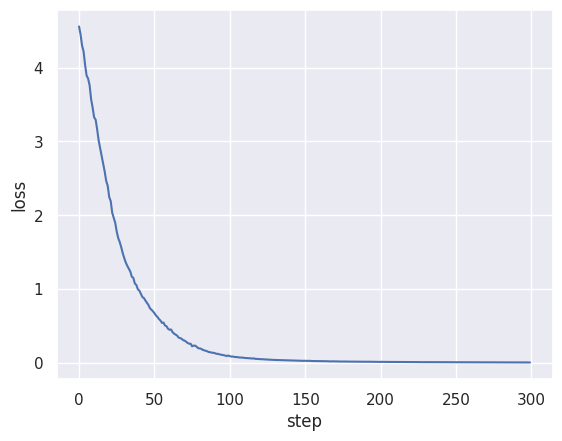

In [298]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

sns.set_theme()

df = pd.DataFrame({
    'loss': metrics['loss'],
    'step': np.arange(metrics['loss'].size)
})

sns.lineplot(df, x='step', y='loss')
plt.show()

In [299]:
TEST_STEPS = 500
batch, _ = sample_obs_modelling_batch(_rng, rollout_steps=TEST_STEPS)
inputs, next_obs, dones_mask = process_inps(batch)

In [300]:
next_obs.shape

(499, 4, 20)

In [301]:
next_goals_pos, next_agent_pos = get_goals_and_pos(next_obs)
next_goals_pos.shape, next_goals_pos[0]

((499, 4, 2),
 Array([[3, 3],
        [3, 2],
        [2, 4],
        [2, 4]], dtype=int32))

In [302]:
def logits_to_real_obs(logits, n_envs=4, temp=0.1):
    env_states = logits.reshape((-1, n_envs, 2, 2, 5))

    agent_pos_x = env_states[:, :, 0, 0]
    agent_pos_y = env_states[:, :, 0, 1]
    goal_pos_x = env_states[:, :, 1, 0]
    goal_pos_y = env_states[:, :, 1, 1]

    return jnp.concatenate(
        [
            jax.nn.softmax(agent_pos_x / temp),
            jax.nn.softmax(agent_pos_y / temp),
            jax.nn.softmax(goal_pos_x / temp),
            jax.nn.softmax(goal_pos_y / temp)
        ], axis=-1
    )

In [303]:
pred_next_obs_logits = transition_model.apply(train_state.params, inputs)
pred_next_obs = logits_to_real_obs(pred_next_obs_logits)

In [304]:
precision = 5
n_correct = (dones_mask * (next_obs == pred_next_obs.round(precision)).all(axis=-1)).sum()
accuracy = n_correct.sum() / dones_mask.sum()
accuracy

Array(1., dtype=float32)

In [334]:
pred_next_obs_logits = transition_model.apply(train_state.params, inputs)
# pred_next_obs = logits_to_real_obs(pred_next_obs_logits)[0].round()
pi, *_ = pretrained_policy(obs)
pred_act = pi.sample(seed=jax.random.PRNGKey(0))
inputs = (jax.nn.one_hot(pred_act, 5), pred_next_obs)

In [337]:
inputs[0][0]

Array([[0., 0., 0., 0., 1.],
       [0., 0., 1., 0., 0.],
       [0., 0., 1., 0., 0.],
       [0., 0., 1., 0., 0.]], dtype=float32)

In [339]:
action[0]

Array([[0., 0., 0., 0., 1.],
       [0., 0., 1., 0., 0.],
       [0., 0., 1., 0., 0.],
       [0., 0., 0., 1., 0.]], dtype=float32)

In [ ]:
def compute_compounding_obs_preds(obs, inps):
    act_next_obs, dones_mask, actions = inps
    # pi, *_ = pretrained_policy(obs)
    # pred_act = pi.sample(seed=jax.random.PRNGKey(0))
    # inputs = (jax.nn.one_hot(pred_act, 5), pred_obs)
    inputs = (actions, obs)
    pred_next_obs_logits = transition_model.apply(train_state.params, inputs)
    pred_next_obs = logits_to_real_obs(pred_next_obs_logits)[0].round()

    next_obs = jnp.where(
        (dones_mask == 0)[:, None], act_next_obs, pred_next_obs
    )

    return next_obs, pred_next_obs

batch, _ = sample_obs_modelling_batch(_rng, rollout_steps=TEST_STEPS)
(action, obs), next_obs, dones_mask = process_inps(batch)

_, compounded_pred_next_obs = jax.lax.scan(
    compute_compounding_obs_preds, obs[0], (next_obs, dones_mask, action)
)

In [324]:
precision = 5
n_correct = (dones_mask * (next_obs == compounded_pred_next_obs.round(precision)).all(axis=-1)).sum()
accuracy = n_correct.sum() / dones_mask.sum()
accuracy

Array(1., dtype=float32)

In [256]:
T = 4
ENV_IDX = 1
print(dones_mask[:T, ENV_IDX])
goal_pos, agent_pos = get_goals_and_pos(pred_next_obs[:T])
print_episode(goal_pos[:, ENV_IDX].tolist(), agent_pos[:, ENV_IDX].tolist())

[1. 1. 0. 1.]
---------------------	---------------------	---------------------	---------------------
|   |   |   |   |   |	|   |   |   |   |   |	|   |   |   |   |   |	|   |   |   |   |   |
---------------------	---------------------	---------------------	---------------------
|   |   |   |   | X |	|   |   |   | X |   |	|   |   |   |   | X |	|   |   |   |   | G |
---------------------	---------------------	---------------------	---------------------
|   |   |   | G |   |	|   |   |   | G |   |	|   |   |   | G |   |	|   |   | X |   |   |
---------------------	---------------------	---------------------	---------------------
|   |   |   |   |   |	|   |   |   |   |   |	|   |   |   |   |   |	|   |   |   |   |   |
---------------------	---------------------	---------------------	---------------------
|   |   |   |   |   |	|   |   |   |   |   |	|   |   |   |   |   |	|   |   |   |   |   |
---------------------	---------------------	---------------------	---------------------
			


In [294]:
T = 4
goal_pos, agent_pos = get_goals_and_pos(next_obs[:T])
print_episode(goal_pos[:, ENV_IDX].tolist(), agent_pos[:, ENV_IDX].tolist())

---------------------	---------------------	---------------------	---------------------
|   |   |   |   |   |	|   |   |   |   |   |	|   |   |   |   |   |	|   |   |   |   |   |
---------------------	---------------------	---------------------	---------------------
|   |   |   |   | X |	|   |   |   |   |   |	|   |   |   |   | G |	|   |   |   |   | G |
---------------------	---------------------	---------------------	---------------------
|   |   |   | G |   |	|   |   |   | G | X |	|   | X |   |   |   |	|   |   | X |   |   |
---------------------	---------------------	---------------------	---------------------
|   |   |   |   |   |	|   |   |   |   |   |	|   |   |   |   |   |	|   |   |   |   |   |
---------------------	---------------------	---------------------	---------------------
|   |   |   |   |   |	|   |   |   |   |   |	|   |   |   |   |   |	|   |   |   |   |   |
---------------------	---------------------	---------------------	---------------------
			


In [237]:
pred_next_obs[:5, 0].round(3), next_obs[:5, 0]

(Array([[0., 1., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 1., 0., 0.,
         0., 0., 1., 0.],
        [0., 0., 1., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 1., 0., 0.,
         0., 0., 1., 0.],
        [0., 0., 0., 1., 0., 0., 0., 1., 0., 0., 0., 0., 0., 1., 0., 0.,
         0., 0., 1., 0.],
        [0., 0., 0., 0., 1., 0., 0., 1., 0., 0., 0., 0., 0., 1., 0., 0.,
         0., 0., 1., 0.],
        [0., 0., 0., 1., 0., 0., 1., 0., 0., 0., 0., 0., 0., 1., 0., 0.,
         0., 1., 0., 0.]], dtype=float32),
 Array([[0., 1., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 1., 0., 0.,
         0., 0., 1., 0.],
        [0., 0., 1., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 1., 0., 0.,
         0., 0., 1., 0.],
        [0., 0., 0., 1., 0., 0., 0., 1., 0., 0., 0., 0., 0., 1., 0., 0.,
         0., 0., 1., 0.],
        [0., 0., 0., 1., 0., 1., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0.,
         0., 1., 0., 0.],
        [0., 0., 0., 1., 0., 0., 1., 0., 0., 0., 0., 0., 0., 1., 0., 0.,
         0., 1., 0.

In [234]:
n_correct

Array([4., 3., 1., 2., 3., 2., 3., 3., 1., 3., 1., 2., 1., 1., 3., 0., 1.,
       1., 2., 2., 2., 3., 2., 2., 3., 2., 1., 1., 3., 1., 1., 2., 2., 3.,
       1., 3., 1., 1., 0., 2., 3., 2., 2., 4., 4., 3., 1., 4., 0., 3., 2.,
       2., 2., 1., 2., 3., 3., 4., 3., 2., 1., 1., 1., 2., 2., 2., 3., 2.,
       2., 0., 3., 0., 1., 3., 1., 0., 3., 3., 1., 1., 2., 2., 2., 1., 3.,
       2., 3., 3., 1., 0., 1., 3., 0., 2., 1., 2., 4., 2., 2., 4., 1., 1.,
       2., 1., 3., 2., 1., 2., 1., 0., 2., 3., 2., 0., 1., 4., 3., 2., 3.,
       2., 1., 4., 2., 2., 2., 2., 3., 1., 1., 3., 1., 3., 3., 2., 2., 0.,
       2., 1., 0., 1., 2., 0., 2., 3., 3., 2., 3., 2., 4., 0., 3., 3., 1.,
       3., 3., 3., 1., 3., 2., 2., 1., 2., 2., 1., 2., 4., 3., 1., 2., 1.,
       2., 2., 2., 3., 2., 4., 0., 0., 2., 3., 2., 1., 1., 3., 1., 3., 1.,
       1., 2., 2., 3., 0., 2., 0., 3., 1., 1., 1., 1., 1., 3., 2., 1., 0.,
       2., 3., 2., 2., 2., 2., 0., 2., 3., 1., 3., 1., 0., 2., 2., 2., 2.,
       2., 2., 1., 2., 1.